# **Desafio - Bázico**
### **Por Vitor Anfrizio**

Para este desafio, usei as bibliotecas _pandas_, _numpy_, _matplotlib_ e _pickle_.

Como usei o _Google Colab_ como ambiente, fiz o upload do arquivo "vendas_de_produtos.csv" no _Google Drive_.

De início, modifiquei a coluna "Data" para o formato aceitável de data e criei uma coluna que indica se a compra foi feita nos últimos 14 dias. Após isso, transformei as descrições em variáveis categóricas, removi dados nulos e algumas colunas que não seriam necessárias à análise.

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

dados = pd.read_excel("/content/drive/MyDrive/vendas_de_produtos.xlsx")

Mounted at /content/drive


In [3]:
dados['Data'] = pd.to_datetime(dados['Data']) 
dados['Compra_14_Dias'] = (dados['Data'].max() - dados['Data']).dt.days <= 14
dados['Categoria_Produto'] = pd.Categorical(dados['Descrição_Produto']).codes

In [4]:
dados = dados.drop(['ID_Produto', 'Descrição_Produto', 'ID_Pedido', 'Preço_Unitário', 'Desconto'], axis=1)
dados = dados[dados['ID_Cliente'].notna()]
dados = dados[dados['Data'].notna()]
dados = dados[dados['Compra_14_Dias'].notna()]

A partir deste ponto, separei os dados em conjuntos de treino e teste, usando a função train_test_split. Os dados de entrada, que são as informações dos clientes, foram selecionados usando a função drop. A partir daqui começa a parte preditiva.

70% dos dados foram usados para treino (X_train e y_train) e 30% para teste (X_test e y_test). Essa divisão permitiu avaliar a capacidade de generalização do modelo.

Daqui, criei uma instância da classe LogisticRegression e usei a função fit para treinar o modelo nos dados de treino. Fiz isso para encontrar os coeficientes da equação de regressão logística que se ajustam melhor aos dados.

Como último ponto até aqui, usei o modelo treinado para fazer previsões nos dados de teste (y_pred) e comparei com as respostas reais (y_test) pra avaliar a qualidade do modelo.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    dados.drop(['ID_Cliente', 'Data', 'Compra_14_Dias'], axis=1),
    dados['Compra_14_Dias'],
    test_size=0.3,
    random_state=42
)

In [6]:
modelo = LogisticRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.88      1.00      0.93      4471
        True       1.00      0.00      0.01       637

    accuracy                           0.88      5108
   macro avg       0.94      0.50      0.47      5108
weighted avg       0.89      0.88      0.82      5108



Como visto acima, o modelo gerado teve uma acurácia de 88% (previu corretamenta, em 88% das vezes, se um cliente faria uma nova compra nos próximos 14 dias ou não). 

Em contrapartida, o recall da classe "True" (propensos a fazer recompra) ficou zerado (o modelo não conseguiu identificar corretamente nenhum cliente que realmente fez uma nova compra nesse período), indicando que o modelo precisa de alguns ajustes.

Uma das soluções que me veio à mente foi o uso da técnica SMOTE (Synthetic Minority Over-sampling Technique) pra gerar, com base nas observações que já existem, novas observações sintéticas para a classe dos clientes que fizeram recompra.

Para isso, usei a biblioteca _imbalanced-learn_. Apliquei a SMOTE no conjunto de treino, retreinei o modelo e fiz as previsões com o conjunto reamostrado

In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [9]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train_res, y_train_res)

y_pred = modelo.predict(X_test)

print(classification_report(y_test, y_pred))

# Salvando o modelo
with open('modelo_classificacao.pkl', 'wb') as arquivo_modelo:
    pickle.dump(modelo, arquivo_modelo)

              precision    recall  f1-score   support

       False       0.94      0.85      0.90      4471
        True       0.38      0.62      0.47       637

    accuracy                           0.83      5108
   macro avg       0.66      0.74      0.68      5108
weighted avg       0.87      0.83      0.84      5108



Com a aplicação da SMOTE, houve uma melhora no recall da classe de clientes que farão recompra (minoritária), passando de 0.0 para 0.65. No entanto, a precisão da classe minoritária caiu, passando de 1.0 para 0.36, indicando que o modelo está prevendo muitos falsos positivos. Em termos mais claros: o modelo está "acertando" 65% das recompras, mas indica que 35% dos clientes que não farão recompra, na verdade, farão.

Apesar disso, apliquei a curva ROC para avaliar melhor o desempenho do modelo. Separei o conjunto de teste, calculei as probabilidades de classe, AUC e plotei o gráfico da curva:

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [11]:
X_test = dados.drop(['ID_Cliente', 'Data', 'Compra_14_Dias'], axis=1)
y_test = dados['Compra_14_Dias']

In [12]:
y_pred = modelo.predict(X_test)
y_prob = modelo.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

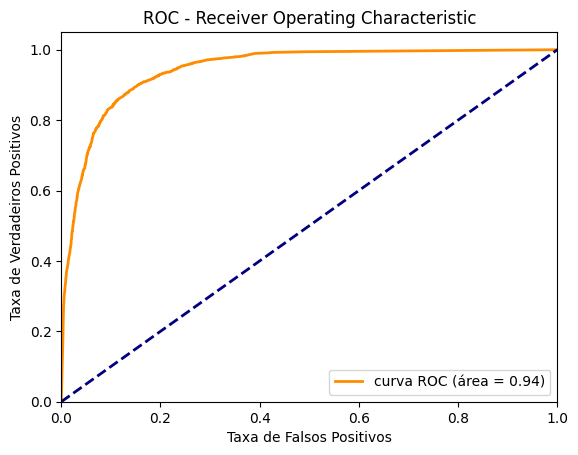

In [13]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label='curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('ROC - Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Após a aplicação do SMOTE, a área da curva ROC, indicada no gráfico acima, foi de 0.94, indicando que o modelo teve um desempenho bastante satisfatório, sendo capaz distinguir muito bem entre as classes positivas e negativas, tendo uma alta taxa de assertividade. Abaixo, seguem as tabelas pré e pós-aplicação da SMOTE:

### Pre-SMOTE		
|                  | Precision | Recall | F1-Score | Support |
|------------------|-----------|--------|----------|---------|
| False            | 0.88      | 1.00   | 0.93     | 4471    |
| True             | 1.00      | 0.00   | 0.01     | 637     |
| Accuracy         |       |     | 0.88     | 5108    |
| Macro Average    | 0.94      | 0.5    | 0.47     | 5108    |
| Weighted Average | 0.98      | 0.88   | 0.82     | 5108    |



### Post-SMOTE
|                  | Precision | Recall | F1-Score | Support |
|------------------|-----------|--------|----------|---------|
| False            | 0.94      | 0.84   | 0.89     | 2991    |
| True             | 0.36      | 0.65   | 0.47     | 415     |
| Accuracy         |       |     | 0.82     | 3406    |
| Macro Average    | 0.65      | 0.74    | 0.68     | 3406    |
| Weighted Average | 0.87      | 0.82   | 0.84     | 3406    |

Para finalizar, carreguei o modelo salvo e apliquei ao conjunto de clientes que ainda não fizeram uma recompra. Daí, classifiquei-os de acordo com as probabilidades geradas pelo modelo. No final, "imprimi" a lista de clientes ordenada por probabilidade de recompra e, logo após, imprimi a lista dos 100 clientes com a maior probabilidade de recompra, segundo o modelo.

In [14]:
with open('modelo_classificacao.pkl', 'rb') as arquivo_modelo:
    modelo_carregado = pickle.load(arquivo_modelo)

In [17]:
probabilidades = modelo_carregado.predict_proba(X_test)[:, 1]

dados_probabilidades = pd.DataFrame({'ID_Cliente': X_test.index, 'Probabilidade_Recompra': probabilidades})
dados_probabilidades = dados_probabilidades.sort_values(by=['Probabilidade_Recompra'], ascending=False)

print(dados_probabilidades)

       ID_Cliente  Probabilidade_Recompra
15894       15894                     1.0
16195       16195                     1.0
12851       12851                     1.0
12866       12866                     1.0
16301       16301                     1.0
...           ...                     ...
8666         8666                     0.0
8667         8667                     0.0
8668         8668                     0.0
2993         2993                     0.0
0               0                     0.0

[17026 rows x 2 columns]


In [18]:
top_100_clientes = dados_probabilidades.head(100)['ID_Cliente'].tolist()
print(top_100_clientes)

[15894, 16195, 12851, 12866, 16301, 12902, 12903, 16741, 3036, 8347, 12937, 16295, 16291, 16290, 8155, 8154, 8153, 8141, 16278, 16277, 3098, 1962, 16275, 16273, 7875, 16733, 8521, 16305, 16355, 16382, 12427, 9190, 16379, 16371, 16368, 12474, 16703, 16357, 16705, 16710, 16306, 8696, 8671, 3006, 16333, 16331, 16320, 12664, 16317, 16727, 12774, 7852, 7849, 16765, 13548, 233, 16549, 16211, 3193, 16779, 16780, 16781, 16210, 16784, 16785, 13551, 13280, 7267, 16207, 16790, 13599, 7265, 214, 16203, 13626, 13654, 16198, 16214, 16231, 7813, 13233, 16272, 7729, 16268, 13145, 16257, 16256, 16775, 16251, 256, 255, 252, 238, 13251, 16247, 16240, 16778, 3164, 16239, 16238]
